_ColormakerRegistry()

[utils.py:141 - _init_num_threads()] NumExpr defaulting to 8 threads.
[tautomers.py:48 - __init__()] Nr of conformations generated per tautomer: 20
[tautomers.py:49 - __init__()] Chirality enforced: True
[tautomers.py:431 - _perform_tautomer_transformation()] Index of atom that moves: 11.


SAMPLmol2
0.15


[tautomers.py:443 - _perform_tautomer_transformation()] Index of atom that donates hydrogen: 0
[tautomers.py:461 - _perform_tautomer_transformation()] Index of atom that accepts hydrogen: 10


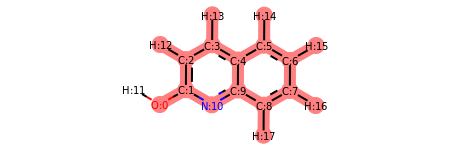

[tautomers.py:165 - add_droplet()] Adding droplet ...


Adding restraint to center to 19
Adding restraint to center to 22
Adding restraint to center to 25
Adding restraint to center to 28
Adding restraint to center to 31
Adding restraint to center to 34
Adding restraint to center to 37
Adding restraint to center to 40
Adding restraint to center to 43
Adding restraint to center to 46
Adding restraint to center to 49
Adding restraint to center to 52
Adding restraint to center to 55
Adding restraint to center to 58
Adding restraint to center to 61
Adding restraint to center to 64
Adding restraint to center to 67
Adding restraint to center to 70
Adding restraint to center to 73
Adding restraint to center to 76
Adding restraint to center to 79
Adding restraint to center to 82
Adding restraint to center to 85
Adding restraint to center to 88
Adding restraint to center to 91
Adding restraint to center to 94
Adding restraint to center to 97
Nr of atoms: 100


[restraints.py:180 - __init__()] Center Of Mass restraint added.


0.15
Begin minimizing...


[ani.py:518 - forward()] Stddev: 67.5198868217168 kJ/mol
[ani.py:518 - forward()] Stddev: 50.0413881226612 kJ/mol
[ani.py:163 - minimize()] Minimization status: False
  0%|          | 0/1000 [00:00<?, ?it/s]

         Current function value: -6666963.697589
         Iterations: 457
         Function evaluations: 556
         Gradient evaluations: 544


100%|██████████| 1000/1000 [02:55<00:00,  5.70it/s, |force|=1.31e+4]


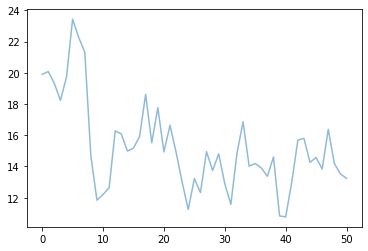

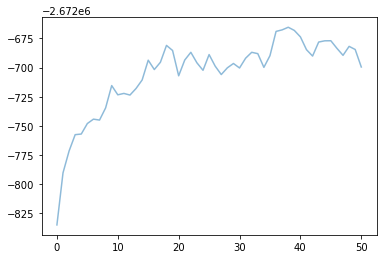

100%|██████████| 1000/1000 [03:05<00:00,  5.40it/s, |force|=1.31e+4]


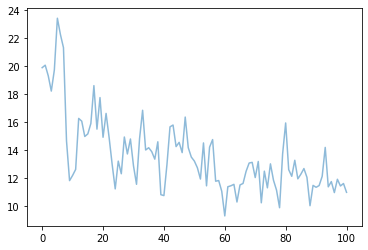

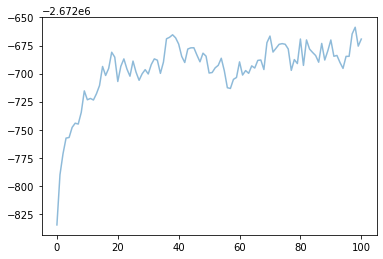

 56%|█████▌    | 555/1000 [01:45<01:40,  4.45it/s, |force|=1.23e+4]

In [ ]:
%matplotlib inline

from simtk import unit
import numpy as np
from tqdm import tqdm
import mdtraj as md
import nglview
from rdkit import Chem
from rdkit.Chem import AllChem
import neutromeratio
import matplotlib.pyplot as plt
import pickle
import torchani
import torch
from neutromeratio.constants import device, platform, kT, exclude_set
import sys, os
from tqdm import tqdm


# name of the system
idx = 4
# number of steps
n_steps = 10000
# diameter
diameter_in_angstrom = 12
# where to write the results
base_path = 'test'

mode = 'forward'

protocol = []
exp_results = pickle.load(open('../data/exp_results.pickle', 'rb'))
for name in sorted(exp_results):
    if name in exclude_set:
        continue
    for lambda_value in np.linspace(0,1,21):
        protocol.append((name, np.round(lambda_value, 2)))

name, lambda_value = protocol[idx-1]
print(name)
print(lambda_value)

t1_smiles = exp_results[name]['t1-smiles']
t2_smiles = exp_results[name]['t2-smiles']

# generate both rdkit mol
tautomer = neutromeratio.Tautomer(name=name, initial_state_mol=neutromeratio.generate_rdkit_mol(t1_smiles), final_state_mol=neutromeratio.generate_rdkit_mol(t2_smiles), nr_of_conformations=20)
if mode == 'forward':
    tautomer.perform_tautomer_transformation_forward()
elif mode == 'reverse':
    tautomer.perform_tautomer_transformation_reverse()
else:
    raise RuntimeError('No tautomer reaction direction was specified.')

os.makedirs(f"{base_path}/{name}", exist_ok=True)
m = tautomer.add_droplet(tautomer.hybrid_topology, 
                            tautomer.hybrid_coords, 
                            diameter=diameter_in_angstrom * unit.angstrom,
                            restrain_hydrogens=True,
                            file=f"{base_path}/{name}/{name}_in_droplet_{mode}.pdb")

# define the alchemical atoms
alchemical_atoms=[tautomer.hybrid_hydrogen_idx_at_lambda_1, tautomer.hybrid_hydrogen_idx_at_lambda_0]

print('Nr of atoms: {}'.format(len(tautomer.ligand_in_water_atoms)))


# extract hydrogen donor idx and hydrogen idx for from_mol
model = neutromeratio.ani.LinearAlchemicalDualTopologyANI(alchemical_atoms=alchemical_atoms,
                                                            adventure_mode=False,
                                                            per_atom_thresh=0.5 * unit.kilojoule_per_mole
)
model = model.to(device)
torch.set_num_threads(2)

# perform initial sampling
energy_function = neutromeratio.ANI1_force_and_energy(
                                        model = model,
                                        atoms = tautomer.ligand_in_water_atoms,
                                        mol = None,
                                        )

tautomer.add_COM_for_hybrid_ligand(np.array([diameter_in_angstrom/2, diameter_in_angstrom/2, diameter_in_angstrom/2]) * unit.angstrom)

for r in tautomer.ligand_restraints:
    energy_function.add_restraint(r)

for r in tautomer.hybrid_ligand_restraints:
    energy_function.add_restraint(r)

for r in tautomer.solvent_restraints:
    energy_function.add_restraint(r)

for r in tautomer.com_restraints:
    energy_function.add_restraint(r)

print(lambda_value)
energy_and_force = lambda x : energy_function.calculate_force(x, lambda_value)
langevin = neutromeratio.LangevinDynamics(atoms = tautomer.ligand_in_water_atoms,                            
                            energy_and_force = energy_and_force)

x0 = tautomer.ligand_in_water_coordinates
x0, e_history = energy_function.minimize(x0, maxiter=1000, lambda_value=lambda_value) 

n_steps_junk = int(n_steps/10)

equilibrium_samples_global = []
energies_global = []
bias_global = []
stddev_global = []

for n_steps in [n_steps_junk] *10:
    equilibrium_samples, energies, bias, stddev = langevin.run_dynamics(x0, 
                                                                n_steps=round(n_steps), 
                                                                stepsize=0.5 * unit.femtosecond, 
                                                                progress_bar=True)
    
    # set new x0
    x0 = equilibrium_samples[-1]

    # add to global list
    equilibrium_samples_global += equilibrium_samples
    energies_global += energies
    bias_global += bias
    stddev_global += stddev

    # save equilibrium energy values 
    f = open(f"{base_path}/{name}/{name}_lambda_{lambda_value:0.4f}_energy_in_droplet_{mode}.csv", 'w+')
    for e in energies_global[::20]:
        e_unitless = e / kT
        f.write('{}\n'.format(e_unitless))
    f.close()
    
    
    
    e_unitless = []
    for e in stddev_global[::20]: 
        e_unitless.append(e / kT)
    plt.plot(e_unitless, alpha=0.5)
    plt.show()

    
    
    e_unitless = []
    for e in energies_global[::20]: 
        e_unitless.append(e / kT)
    plt.plot(e_unitless, alpha=0.5)
    plt.show()


    f = open(f"{base_path}/{name}/{name}_lambda_{lambda_value:0.4f}_bias_in_droplet_{mode}.csv", 'w+')
    for e in bias_global[::20]:
        e_unitless = e / kT
        f.write('{}\n'.format(e_unitless))
    f.close()


    equilibrium_samples_in_nm = [x.value_in_unit(unit.nanometer) for x in equilibrium_samples_global]
    ani_traj = md.Trajectory(equilibrium_samples_in_nm[::20], tautomer.ligand_in_water_topology)
    ani_traj.save(f"{base_path}/{name}/{name}_lambda_{lambda_value:0.4f}_in_droplet_{mode}.dcd", force_overwrite=True)



In [1]:
import torchani

In [2]:
torchani.__version__

'0.9'